# Heart Disease Database

## Heart disease diagnosis

* The data was collected from the Cleveland Clinic Foundation (the only one that has been used by ML researchers)
* While the databases have $76$ raw attributes (only $14$ of them are actually used)
* The "goal" field refers to the presence of heart disease in the patient (integer valued from $0$ "no presence" to $4$)
* Experiments have concentrated on simply attempting to distinguish presence (values $1,2,3,4$) from absence (value $0$)

## Data Attributes

* All attributes are numeric-valued
* Number of Instances in Cleveland data set: 303
* Number of selected attributes in processed file (only 14 used)
* The names and social security numbers of the patients were replaced with dummy values


    1. age: in years
    2. sex: (1 = male; 0 = female)
    3. cp: chest pain location (1 = substernal; 0 = otherwise)
    4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
    5. chol: serum cholestoral in mg/dl
    6. fbs: fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
    7. restecg: resting electrocardiographic results
        - Value 0: normal
        - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
    8. thalach: maximum heart rate achieved
    9. exang: exercise induced angina (1 = yes; 0 = no)
    10. oldpeak: ST depression induced by exercise relative to rest
    11. slope: the slope of the peak exercise ST segment
        - Value 1: upsloping
        - Value 2: flat
        - Value 3: downsloping
    12. ca: number of major vessels (0-3) colored by flourosopy
    13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
    14. num (the predicted attribute): diagnosis of heart disease (angiographic disease status)
        - Value 0: < 50% diameter narrowing
        - Value 1: > 50% diameter narrowing



In [2]:
# import packages
import numpy as np
import pandas as pd

# set random seed to ensure reproducibility of results
RANDOM_SEED = 42

## Load data and add header (column names)

In [3]:
# Load data file
data_file = "../data/processed.cleveland.data"
col_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca',
           'thal', 'num']
data_df = pd.read_csv(data_file, sep=',', names=col_names)

print(data_df.head())

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  num  
0    3.0  0.0  6.0    0  
1    2.0  3.0  3.0    2  
2    2.0  2.0  7.0    1  
3    3.0  0.0  3.0    0  
4    1.0  0.0  3.0    0  


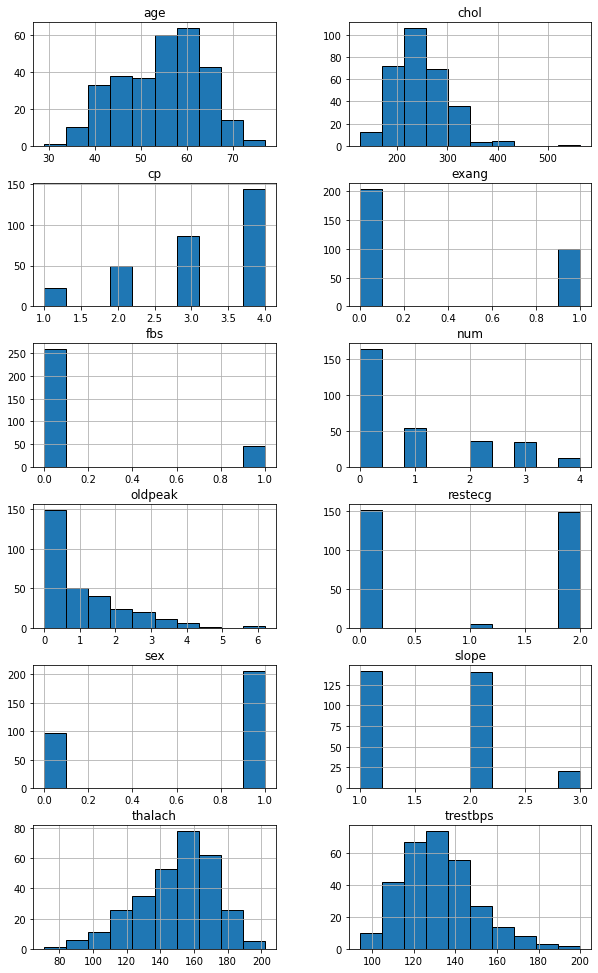

In [4]:
# Check the distribution of each feature in the data by plotting its histogram
data_df.hist(grid=True, figsize=(10,20), layout=(7,2), edgecolor='black');

## Inspect and clean data

* Some of the cell values are missing (value = '?') - 6 Instances
* Instances with missing attributes are removed (it can be also replaced with the mean value of this attribute from
the training data)

In [5]:
data_clean_df = data_df[~data_df.eq('?').any(1)]    # warning here because of type comparison with a string
# convert all cell values to numeric
data_clean_df = data_clean_df.apply(pd.to_numeric)
# data_clean_df.astype(np.float16)
print(data_clean_df.head())

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  num  
0    3.0  0.0   6.0    0  
1    2.0  3.0   3.0    2  
2    2.0  2.0   7.0    1  
3    3.0  0.0   3.0    0  
4    1.0  0.0   3.0    0  


/Users/amiralansary/PycharmProjects/Sensyne_Health_ML_assignment_042020/venv/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


## Data Split

* Split the data into $70%$ (207) train - $15%$ validation (45) - $15%$ test (45)
* The split is stratified on the 14 features to ensure a similar distribution of these features in each subset

In [6]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def split_data(indexes, stratified_features, test_size=0.5, k_folds=1, random_state=0):
    # first split the data into two parts train and (validation + testing)
    mskf = MultilabelStratifiedShuffleSplit(n_splits=k_folds,
                                            test_size=test_size,
                                            random_state=random_state)
    # the split return k-fold based on n_splits value
    set1_indexes = [0]*k_folds
    set2_indexes = [0]*k_folds
    fold_idx = 0
    # split the data and generate k-folds
    for set1_fold_index, set2_fold_index in mskf.split(indexes, stratified_features):
        set1_indexes[fold_idx], set2_indexes[fold_idx] = \
            indexes[set1_fold_index], indexes[set2_fold_index]
        fold_idx += 1
    return set1_indexes, set2_indexes

In [7]:
indexes = np.array(data_clean_df.index)
features = data_clean_df.to_numpy()
# split data to train and test
train_indexes, test0_indexes =  split_data(indexes, features, test_size=0.3, k_folds=1, random_state=RANDOM_SEED)
# split test to validation and test
test0_df = data_clean_df.loc[test0_indexes[0]]
valid_indexes, test_indexes =  split_data(np.array(test0_df.index), test0_df.to_numpy(), test_size=0.5, k_folds=1, random_state=RANDOM_SEED)


print('train \n', train_indexes[0])
print('valid \n', valid_indexes[0])
print('test \n', test_indexes[0])

train 
 [  0   2   3   4   5   6   7   9  10  12  15  16  17  18  19  20  22  24
  25  27  28  30  31  33  35  37  41  42  43  44  45  46  48  50  51  52
  56  58  59  60  61  62  63  64  65  66  67  68  69  70  72  73  74  75
  76  77  78  79  80  81  82  84  85  86  88  90  91  93  94  95  96  97
  98 102 103 104 105 106 108 109 110 111 112 113 115 117 118 119 120 124
 125 126 127 128 130 132 133 135 137 138 140 141 143 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 164 165 167 168 170 171 172 173 174
 177 178 179 183 184 185 186 187 188 191 193 195 196 198 200 201 202 205
 206 208 209 210 211 212 213 214 216 217 221 223 224 225 226 227 229 231
 232 236 237 238 239 240 241 245 247 248 249 252 253 257 258 259 262 263
 267 268 269 270 271 273 274 275 276 278 279 280 281 282 283 286 288 289
 290 291 292 294 295 296 297 299 301]
valid 
 [  8  11  13  14  29  36  38  39  53  71  92 100 101 107 121 129 134 136
 142 145 146 163 175 181 182 197 207 215 218 219 228 230 234 235 243 2

/Users/amiralansary/PycharmProjects/Sensyne_Health_ML_assignment_042020/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass test_size=0.3, train_size=None, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/amiralansary/PycharmProjects/Sensyne_Health_ML_assignment_042020/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass test_size=0.5, train_size=None, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [8]:
# extract data frames that correspond to the selected indexes
train_df = data_clean_df.loc[train_indexes[0]]
valid_df = data_clean_df.loc[valid_indexes[0]]
test_df = data_clean_df.loc[test_indexes[0]]

print(len(train_df))
print(len(valid_df))
print(len(test_df))

207
45
45


## Data split distribution

* Check distribution is the same between data splits
* The stratification algorithm is expected not to fit to all features, but many of them should've similar distributions

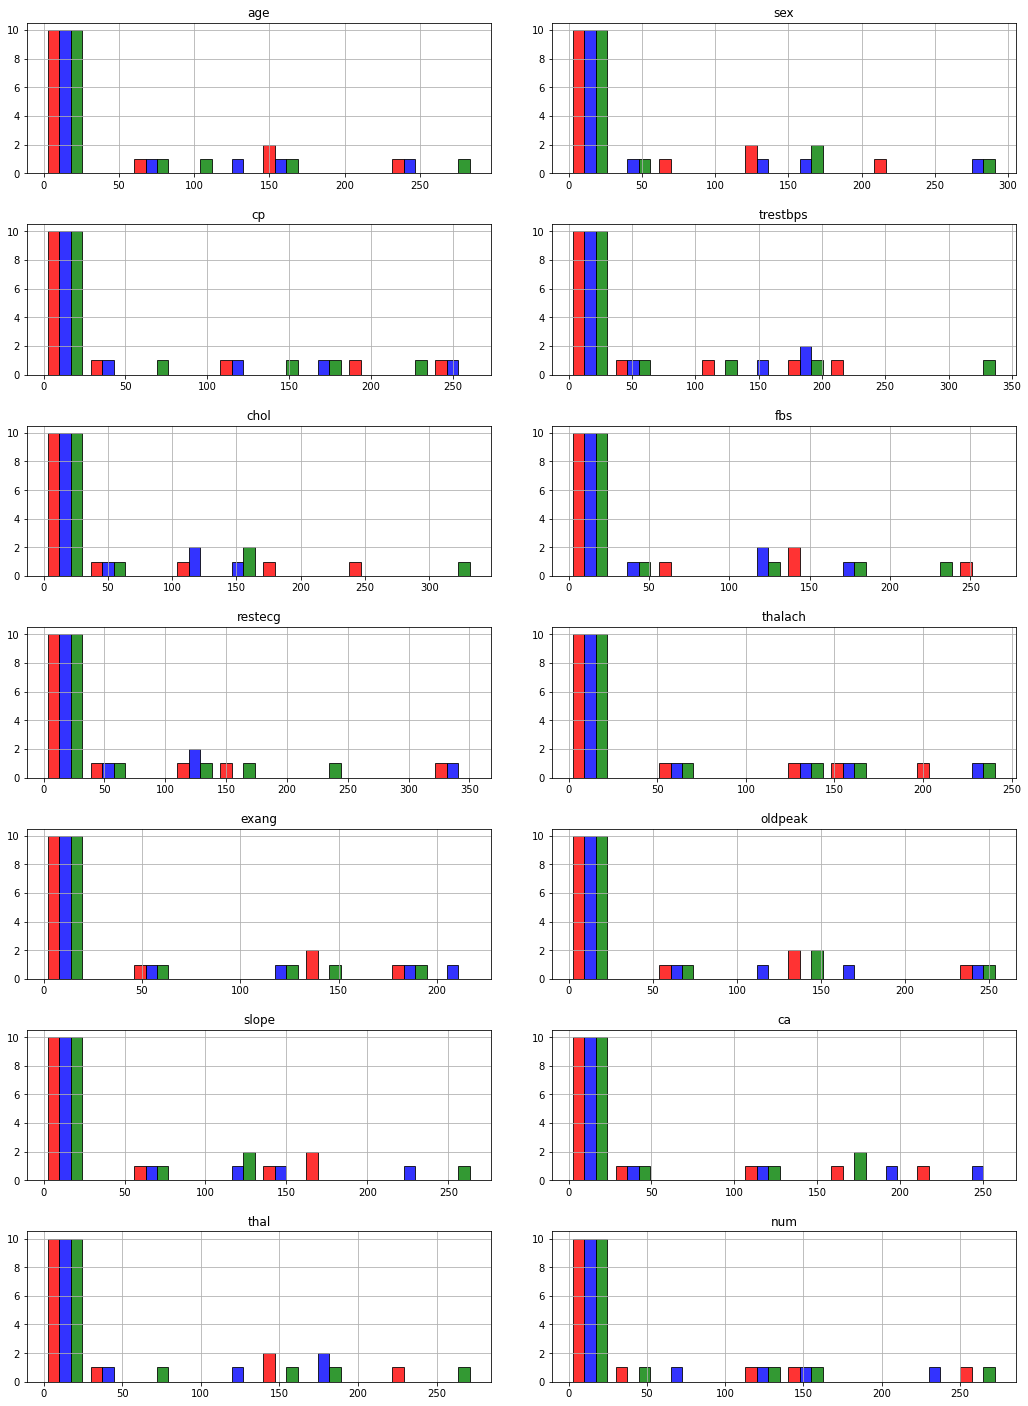

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

colors = ['red', 'blue', 'green']
fig, ax = plt.subplots(7, 2, figsize=(15, 20))
fig.tight_layout(pad=3.0)

axes = ax.flatten()
for i,j in zip(range(14), axes):
    j.hist([train_df.iloc[i], valid_df.iloc[i], test_df.iloc[i]], color=colors, alpha=0.8, edgecolor='black')
    j.grid()
    j.set_title(train_df.columns[i])

# train_df.hist(grid=True, figsize=(10,20), layout=(7,2), edgecolor='black');
# valid_df.hist(grid=True, figsize=(10,20), layout=(7,2), edgecolor='black');
# test_df.hist(grid=True, figsize=(10,20), layout=(7,2), edgecolor='black');
